In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

## Cartera Colectiva

In [3]:
# Reading Data
data_w = pd.read_excel('../raw_data/weekly_data_clean_with_covid_col.xlsx', engine='openpyxl')
data_d = pd.read_excel('../raw_data/daily_data_clean_with_covid_col.xlsx', engine='openpyxl')


In [4]:
# Dropping extra index column
data_w = data_w.drop(columns= 'Unnamed: 0')
data_d = data_d.drop(columns= 'Unnamed: 0')


In [5]:
#Check Nulls
data_w.isnull().sum(), data_d.isnull().sum()

(date_issue      0
 amount          0
 covid_claims    0
 dtype: int64,
 date_issue      0
 amount          0
 covid_claims    0
 dtype: int64)

In [6]:
# Check types and lenght
data_w.dtypes, len(data_w), data_d.dtypes, len(data_d)

(date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 132,
 date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 894)

In [7]:
# Setting index as date
data_w = data_w.set_index('date_issue')
data_d = data_d.set_index('date_issue')


In [8]:
data_d

,amount,covid_claims
date_issue,,
2018-09-02,14,0
2018-09-03,8716,0
2018-09-04,23504,0
2018-09-05,48112,0
2018-09-06,11508,0
...,...,...
2021-03-04,174996,15
2021-03-05,180932,23
2021-03-06,69308,17


<AxesSubplot:xlabel='date_issue'>

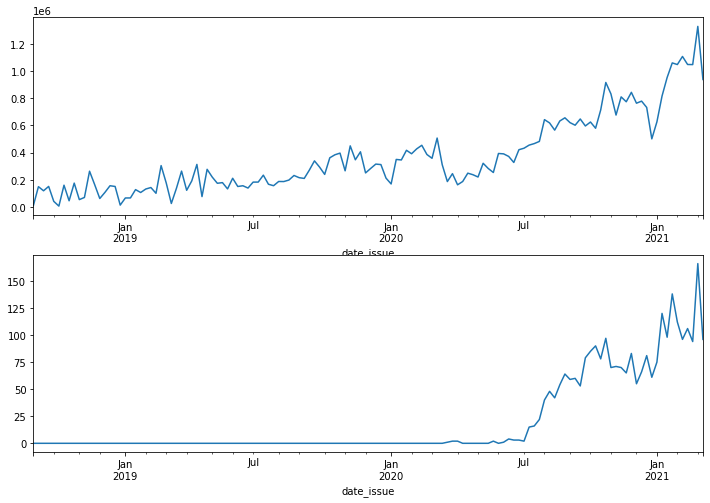

In [9]:
#Plotting weekly
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
data_w['amount'].plot(ax=ax1)
data_w['covid_claims'].plot(ax=ax2)


<AxesSubplot:xlabel='date_issue'>

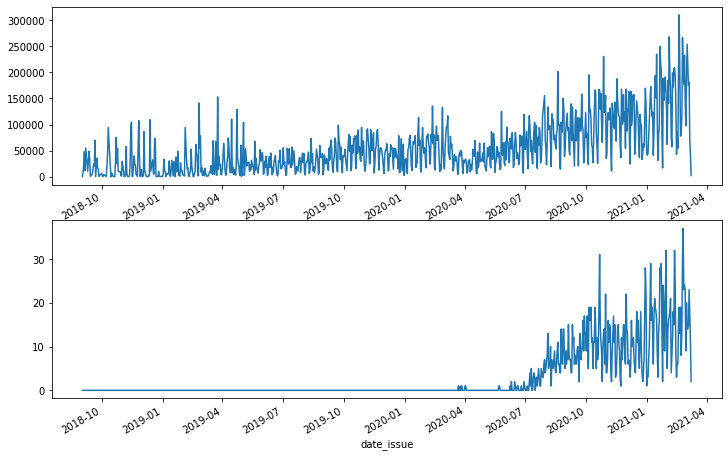

In [10]:
#Plotting daily
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
data_d['amount'].plot(ax=ax1)
data_d['covid_claims'].plot(ax=ax2)

### Trying with weekly data

In [11]:
# Checking for stationarity
pvalue_a = adfuller(data_w['amount'])[1]

pvalue_c = adfuller(data_w['covid_claims'])[1]

def stationary(pvalue):
    if pvalue < 0.05:
        print('TS is stationary')
    else:
        print('TS is not stationary')
stationary(pvalue_a), pvalue_a, stationary(pvalue_c), pvalue_c

TS is not stationary
TS is not stationary


(None, 0.974799663931986, None, 0.991641917186487)

In [12]:
# Splitting Weekly data 

split = 0.8
split_index = round(len(data_w)*split)

train = data_w.iloc[:split_index]
test = data_w.iloc[split_index:]

train.head(1), train.tail(1), test.head(1), test.tail(1)

(            amount  covid_claims
 date_issue                      
 2018-09-03    8730             0,
             amount  covid_claims
 date_issue                      
 2020-09-07  620133            59,
             amount  covid_claims
 date_issue                      
 2020-09-14  601221            60,
             amount  covid_claims
 date_issue                      
 2021-03-08  937722            96)

In [13]:
# Separating variables
endog_train = train.drop(columns = 'covid_claims')
exog_train = train.drop(columns = 'amount')
endog_test = test.drop(columns = 'covid_claims')
exog_test = test.drop(columns = 'amount')

In [14]:
endog_test.head(1), exog_test.head(1), endog_test.tail(1), exog_test.tail(1)


(            amount
 date_issue        
 2020-09-14  601221,
             covid_claims
 date_issue              
 2020-09-14            60,
             amount
 date_issue        
 2021-03-08  937722,
             covid_claims
 date_issue              
 2021-03-08            96)

### Autoarima raw_data without exogenous variable

In [15]:
autoarima_raw = pm.auto_arima(y = endog_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1416.025, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=1.25 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1373.226, Time=0.86 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1383.999, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1366.944, Time=2.09 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1364.944, Time=1.30 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1366.944, Time=4.27 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=inf, Time=4.67 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=1.14 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1366.263, Time=1.67 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=1368.372, Time=1.77 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=1367.818, Time=2.61 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=1366.697, Time=1.69 sec

Best model:  ARIMA(0,1,1)(1,1,0)[52]  

In [16]:
# Split = 0.8
# Best model:  ARIMA(0,1,1)(1,1,0)[52]
# AIC = 1364


autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  106
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -679.472
Date:                             Fri, 12 Mar 2021   AIC                           1364.944
Time:                                     13:52:33   BIC                           1370.855
Sample:                                          0   HQIC                          1367.217
                                             - 106                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3933      0.320     -1.230      0.219      -1.020       0.234
ar.S.L52      -0.9625      0.256     -3.763      0.000      -1.464      -0.461
sigma2      1.386e+10    3.5e-12   3.96e+21      0.000    1.39e+10    1.39e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.86   Prob(JB):                         0.58
Heteroskedasticity (H):               1.02   Skew:                            -0.35
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [17]:
# Build model
best_sarima = SARIMAX(endog= endog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
best_sarima = best_sarima.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [18]:
prediction = best_sarima.get_prediction(start = '2020-09-14', end = '2021-03-08', dynamic = True, full_results = True)


In [19]:
prediction.row_labels

DatetimeIndex(['2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05',
               '2020-10-12', '2020-10-19', '2020-10-26', '2020-11-02',
               '2020-11-09', '2020-11-16', '2020-11-23', '2020-11-30',
               '2020-12-07', '2020-12-14', '2020-12-21', '2020-12-28',
               '2021-01-04', '2021-01-11', '2021-01-18', '2021-01-25',
               '2021-02-01', '2021-02-08', '2021-02-15', '2021-02-22',
               '2021-03-01', '2021-03-08'],
              dtype='datetime64[ns]', freq='W-MON')

In [20]:
predicted_amount = prediction.prediction_results.forecasts[0]

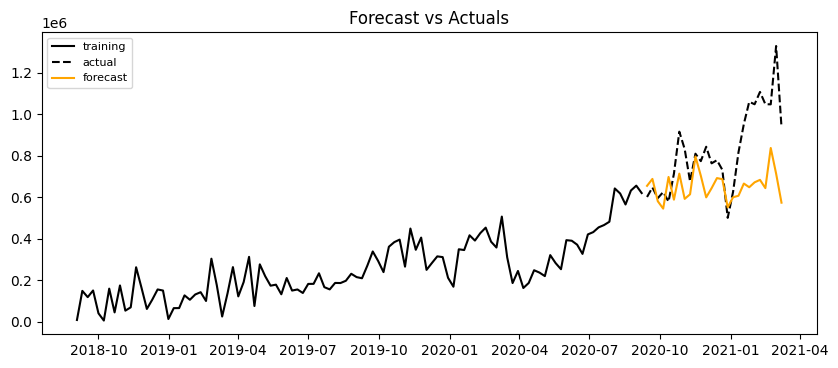

In [21]:
plot_forecast(predicted_amount, endog_train, endog_test)

In [22]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

188141.86562099235

In [23]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.2030153991191624

### Autoarima raw_data with exogenous variable

In [62]:
# Autoarima raw_data with exogenous variable

autoarima_raw = pm.auto_arima(y = endog_train, X= exog_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=1.25 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1559.433, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=1.73 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1372.308, Time=1.16 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1382.896, Time=0.23 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1365.922, Time=2.88 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1363.922, Time=1.86 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1365.922, Time=5.91 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=inf, Time=6.58 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=1.39 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1365.255, Time=2.83 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=1367.410, Time=2.54 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=1366.719, Time=4.89 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=1365.885, Time=2.59 sec

Best model:  ARIMA(0,1,1)(1,1,0)[52]  

In [25]:
autoarima_raw.order


(0, 1, 1)

In [63]:
# Split = 0.8
# Best model:  ARIMA(0,1,1)(1,1,0)[52]
# AIC = 1363

autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  106
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -677.961
Date:                             Fri, 12 Mar 2021   AIC                           1363.922
Time:                                     17:16:48   BIC                           1371.803
Sample:                                 09-03-2018   HQIC                          1366.953
                                      - 09-07-2020                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
covid_claims  3672.1290   6420.529      0.572      0.567   -8911.876    1.63e+04
ma.L1           -0.4255      0.317     -1.344      0.179      -1.046       0.195
ar.S.L52        -0.9630      0.243     -3.959      0.000      -1.440      -0.486
sigma2        1.327e+10      0.000   2.88e+13      0.000    1.33e+10    1.33e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.04
Prob(Q):                              0.99   Prob(JB):                         0.59
Heteroskedasticity (H):               0.77   Skew:                            -0.34
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.12e+30. Standard errors may be unstable.
"""

In [64]:
# Build model
best_sarima = SARIMAX(endog= endog_train, exog= exog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
best_sarima = best_sarima.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [66]:
prediction = best_sarima.get_prediction(start = '2020-09-14', end = '2021-03-08', dynamic = True, full_results = True, exog = exog_test)

In [67]:
prediction.row_labels

DatetimeIndex(['2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05',
               '2020-10-12', '2020-10-19', '2020-10-26', '2020-11-02',
               '2020-11-09', '2020-11-16', '2020-11-23', '2020-11-30',
               '2020-12-07', '2020-12-14', '2020-12-21', '2020-12-28',
               '2021-01-04', '2021-01-11', '2021-01-18', '2021-01-25',
               '2021-02-01', '2021-02-08', '2021-02-15', '2021-02-22',
               '2021-03-01', '2021-03-08'],
              dtype='datetime64[ns]', freq='W-MON')

In [68]:
predicted_amount = prediction.prediction_results.forecasts[0]

In [72]:
predicted_amount.

array([ 665031.09208425,  672710.86759277,  660621.94867324,
        647075.89924725,  818051.21018917,  664467.14006137,
        859835.74963853,  638981.69615926,  664732.09350189,
        843267.67591933,  732086.67759698,  693975.51096296,
        635249.48014554,  724398.16470455,  774261.59278943,
        565032.47975188,  665286.54845932,  837493.65544928,
        815612.73128243,  944698.97063519,  872876.57625735,
        825995.91086944,  822924.86003984,  972417.58212336,
       1113027.99136177,  715999.4387695 ])

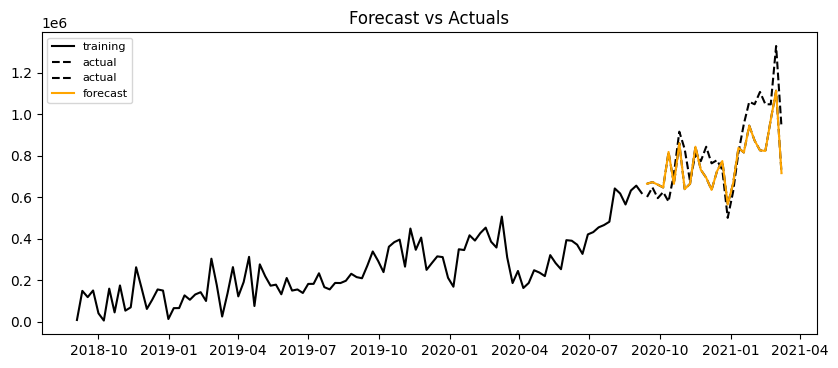

In [69]:
plot_forecast(predicted_amount, endog_train, endog_test)

In [70]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

105527.97677099904

In [71]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.124012539918005

## Trying with daily data

In [34]:
# Splitting Daily data 

split = 0.8
split_index = round(len(data_d)*split)

train_d = data_d.iloc[:split_index]
test_d = data_d.iloc[split_index:]

train_d.head(1), train_d.tail(1), test_d.head(1), test_d.tail(1)

(            amount  covid_claims
 date_issue                      
 2018-09-02      14             0,
             amount  covid_claims
 date_issue                      
 2020-09-10  133760            15,
             amount  covid_claims
 date_issue                      
 2020-09-11   85999            11,
             amount  covid_claims
 date_issue                      
 2021-03-08    2247             2)

In [35]:
# Separating variables
endog_train_d = train_d.drop(columns = 'covid_claims')
exog_train_d = train_d.drop(columns = 'amount')
endog_test_d = test_d.drop(columns = 'covid_claims')
exog_test_d = test_d.drop(columns = 'amount')

In [36]:
endog_test_d.head(1), exog_test_d.head(1), endog_test_d.tail(1), exog_test_d.tail(1)


(            amount
 date_issue        
 2020-09-11   85999,
             covid_claims
 date_issue              
 2020-09-11            11,
             amount
 date_issue        
 2021-03-08    2247,
             covid_claims
 date_issue              
 2021-03-08             2)

### Autoarima raw_data without exogenous variable

In [37]:
autoarima_raw = pm.auto_arima(y = endog_train_d, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=16645.112, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=17048.629, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=16746.333, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=16632.522, Time=0.22 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=16847.830, Time=0.08 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=16615.814, Time=0.43 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=16720.237, Time=0.16 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=16611.534, Time=0.82 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=16621.271, Time=0.42 sec
 ARIMA(1,1,0)(2,1,2)[7]             : AIC=16598.454, Time=0.98 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=16599.848, Time=0.44 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=16597.663, Time=0.65 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=16597.082, Time=0.28 sec
 ARIMA(1,1,0)(0,1,1)[7]  

In [38]:
# Split = 0.8
# Best model:  ARIMA(2,1,2)(0,1,1)[7]
# AIC = 16375


autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  715
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -8181.854
Date:                             Fri, 12 Mar 2021   AIC                          16375.708
Time:                                     13:53:37   BIC                          16403.074
Sample:                                          0   HQIC                         16386.281
                                             - 715                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0711      0.110      9.734      0.000       0.855       1.287
ar.L2         -0.1730      0.077     -2.255      0.024      -0.323      -0.023
ma.L1         -1.8818      0.086    -21.973      0.000      -2.050      -1.714
ma.L2          0.8933      0.080     11.213      0.000       0.737       1.049
ma.S.L7       -0.9033      0.039    -23.197      0.000      -0.980      -0.827
sigma2      1.059e+09   6.79e-11   1.56e+19      0.000    1.06e+09    1.06e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               814.84
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.8e+34. Standard errors may be unstable.
"""

In [39]:
# Build model
best_sarima = SARIMAX(endog= endog_train_d, order=(2, 1, 2),seasonal_order=(0, 1, 1, 7))
best_sarima = best_sarima.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [42]:
endog_test_d

,amount
date_issue,
2020-09-11,85999
2020-09-12,53123
2020-09-13,20387
2020-09-14,99249
2020-09-15,128126
...,...
2021-03-04,174996
2021-03-05,180932
2021-03-06,69308


In [43]:
prediction = best_sarima.get_prediction(start = 715, end = 893, dynamic = True, full_results = True)


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [44]:
prediction.row_labels

RangeIndex(start=715, stop=894, step=1)

In [45]:
predicted_amount = prediction.prediction_results.forecasts[0]

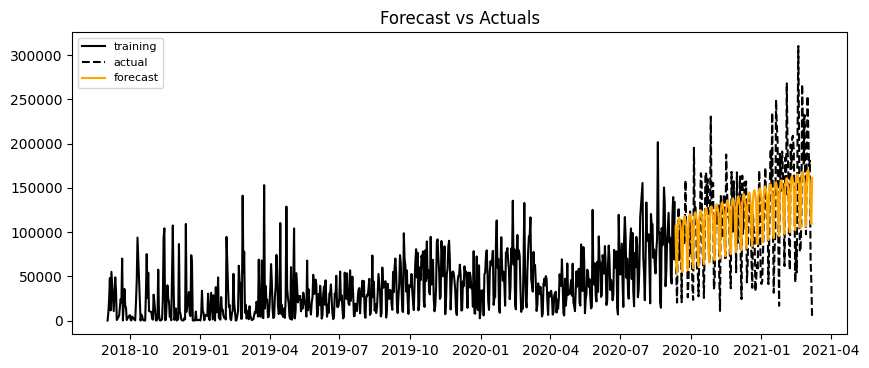

In [46]:
plot_forecast(predicted_amount, endog_train_d, endog_test_d)

In [47]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test_d)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

35627.677001003634

In [48]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.8767025997738042

### Autoarima raw_data with exogenous variable

In [49]:
# Autoarima raw_data with exogenous variable

autoarima_raw = pm.auto_arima(y = endog_train_d, X= exog_train_d, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=16610.068, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=20950.248, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=16722.570, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=16599.875, Time=0.23 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=16819.101, Time=0.11 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=16582.277, Time=0.49 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=16679.680, Time=0.21 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=16576.818, Time=0.71 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=16588.017, Time=0.98 sec
 ARIMA(1,1,0)(2,1,2)[7]             : AIC=16572.023, Time=1.01 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=16574.298, Time=0.49 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=16571.911, Time=0.63 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=16571.624, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[7]  

In [50]:
# Split = 0.8
# Best model:  ARIMA(0,1,2)(0,1,1)[7]
# AIC = 16227


autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  715
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -8108.637
Date:                             Fri, 12 Mar 2021   AIC                          16227.274
Time:                                     13:57:39   BIC                          16250.079
Sample:                                          0   HQIC                         16236.086
                                             - 715                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
covid_claims  4969.9650    731.689      6.792      0.000    3535.880    6404.050
ma.L1           -0.7891      0.037    -21.218      0.000      -0.862      -0.716
ma.L2           -0.1532      0.038     -4.033      0.000      -0.228      -0.079
ma.S.L7         -0.9112      0.020    -46.010      0.000      -0.950      -0.872
sigma2        5.277e+08      0.002    2.5e+11      0.000    5.28e+08    5.28e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               930.60
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.38e+27. Standard errors may be unstable.
"""

In [51]:
best_sarima_d = SARIMAX(endog= endog_train_d, exog= exog_train_d, order=(0, 1, 2),seasonal_order=(0, 1, 1, 7))
best_sarima_d = best_sarima_d.fit()

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [52]:
best_sarima_d

In [53]:
exog_test_d

,covid_claims
date_issue,
2020-09-11,11
2020-09-12,12
2020-09-13,6
2020-09-14,8
2020-09-15,6
...,...
2021-03-04,15
2021-03-05,23
2021-03-06,17


In [54]:
endog_train_d

,amount
date_issue,
2018-09-02,14
2018-09-03,8716
2018-09-04,23504
2018-09-05,48112
2018-09-06,11508
...,...
2020-09-06,41880
2020-09-07,119559
2020-09-08,139589


In [55]:
prediction = best_sarima_d.get_prediction(start = 715, end = 893, dynamic = True, full_results = True, exog = exog_test_d)

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [56]:
predicted_amount = prediction.prediction_results.forecasts[0]

In [57]:
prediction.row_labels

RangeIndex(start=715, stop=894, step=1)

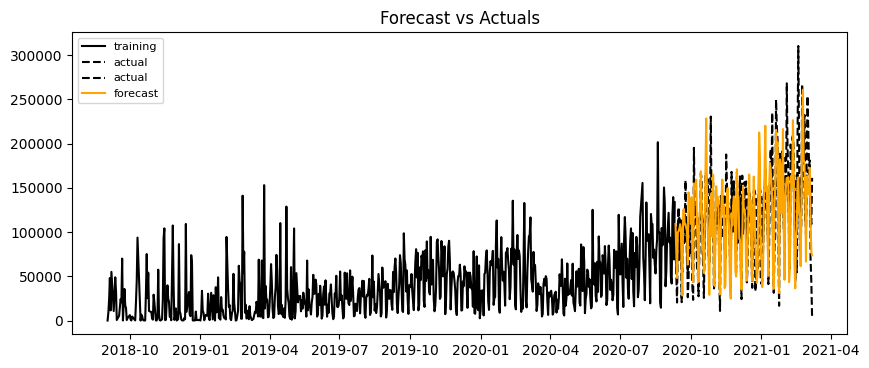

In [58]:
plot_forecast(predicted_amount, endog_train_d, endog_test_d)

In [59]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test_d)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

31144.04821576529

In [60]:
best_sarima_performance

,amount,predicted_amount,absolute_error
date_issue,,,
2020-09-11,85999,109205.792047,23206.792047
2020-09-12,53123,80079.051032,26956.051032
2020-09-13,20387,48093.781215,27706.781215
2020-09-14,99249,99850.250261,601.250261
2020-09-15,128126,101040.682983,27085.317017
...,...,...,...
2021-03-04,174996,142467.459277,32528.540723
2021-03-05,180932,172604.081010,8327.918990
2021-03-06,69308,108711.257655,39403.257655


In [61]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.5055576281920264

### Best Model:  Weekly data with exogenous variable 

SARIMAX(endog= endog_train, exog= exog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))

MAE = 105527.97677099904

MAPE = 0.124012539918005

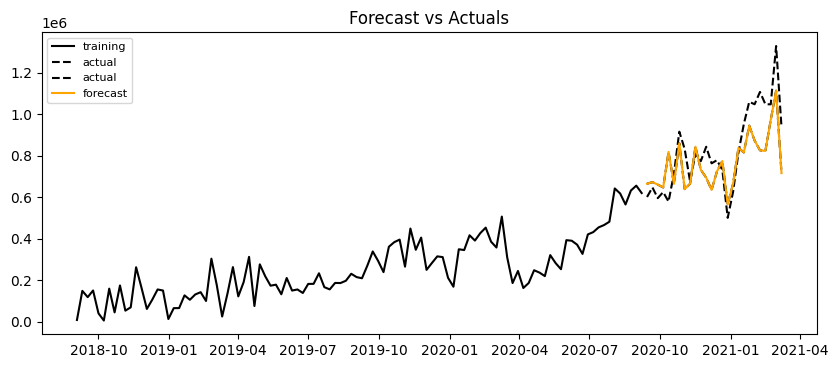

### If no reliable covid proyections are available use Weekly data without exogenous variable

SARIMAX(endog= endog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))

MAE = 188141.86562099235
MAPE = 0.203

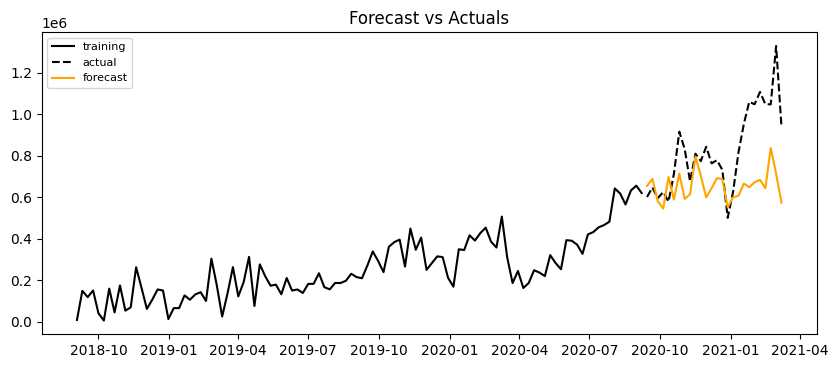